In [24]:
import pandas as pd
import numpy as np

In [25]:
matches = pd.read_csv("../../preparation_before_models/data/matches.csv")

In [26]:
matches['Date'] = pd.to_datetime(matches['Date'])
matches['year'] = matches['Date'].dt.year
matches = matches[matches['year'] > 2017]

In [27]:
missing_values = matches.isnull().sum()

columns_with_nan = missing_values[missing_values > 0]

print("Columns with NaN values and their counts:")
print(columns_with_nan)

Columns with NaN values and their counts:
player1_bet_odds    12
player2_bet_odds    12
dtype: int64


In [28]:
matches['Date'] = pd.to_datetime(matches['Date'])
matches['year'] = matches['Date'].dt.year
# Train: 2018–2021
train_matches = matches[matches['year'] <= 2021]

# Validation: 2022
val_matches = matches[matches['year'] == 2022]

# Test: 2023
test_matches = matches[matches['year'] == 2023]

In [29]:
train_matches_nested = matches[matches['year'] <= 2022]

In [30]:
matches = matches.drop(columns=["year", "Date"])

In [31]:
import torch.nn as nn

In [32]:
weather_cols = ['temperature_2m', 'relative_humidity_2m','windspeed_10m','apparent_temperature']
player1_cols = [col for col in matches.columns if col.startswith('player1_') and "bet" not in col]
player2_cols = [col for col in matches.columns if col.startswith('player2_') and "bet" not in col]
env_cols = [col for col in matches.columns if not  col.startswith('player') and col not in player1_cols and col not in player2_cols and "diff" not in col and "target" not in col and "bet" not in col and col not in weather_cols and "avg" not in col and 'match_id' not in col]
target_col = 'target'
player1_bet = 'player1_bet_odds'
player2_bet = 'player2_bet_odds'
player1_cols

['player1_right_handed',
 'player1_age',
 'player1_rank',
 'player1_entry_LL',
 'player1_entry_Q',
 'player1_entry_WC',
 'player1_is_seeded',
 'player1_1st_serve_in_pct_avg',
 'player1_CO_1st_serve_in_pct_avg',
 'player1_1st_serve_win_pct_avg',
 'player1_CO_1st_serve_win_pct_avg',
 'player1_2nd_serve_in_pct_avg',
 'player1_CO_2nd_serve_in_pct_avg',
 'player1_2nd_serve_win_pct_avg',
 'player1_CO_2nd_serve_win_pct_avg',
 'player1_service_games_won_pct_avg',
 'player1_CO_service_games_won_pct_avg',
 'player1_1st_serve_return_win_pct_avg',
 'player1_CO_1st_serve_return_win_pct_avg',
 'player1_2nd_serve_return_win_pct_avg',
 'player1_CO_2nd_serve_return_win_pct_avg',
 'player1_return_games_win_pct_avg',
 'player1_CO_return_games_win_pct_avg',
 'player1_bp_won_pct_avg',
 'player1_CO_bp_won_pct_avg',
 'player1_bp_saved_pct_avg',
 'player1_CO_bp_saved_pct_avg',
 'player1_elo',
 'player1_surface_elo',
 'player1_blended_elo',
 'player1_fatigue_score',
 'player1_h2h_wins',
 'player1_h2h_surface_w

In [33]:
player1_train = train_matches[player1_cols].values
player2_train = train_matches[player2_cols].values
env_train = train_matches[env_cols].values
y_train = train_matches['target'].values  # Match outcome
player1_bet_odds_train = train_matches['player1_bet_odds'].values
player2_bet_odds_train = train_matches['player2_bet_odds'].values

player1_val = val_matches[player1_cols].values
player2_val = val_matches[player2_cols].values
env_val = val_matches[env_cols].values
y_val = val_matches['target'].values
player1_bet_odds_val = val_matches['player1_bet_odds'].values
player2_bet_odds_val = val_matches['player2_bet_odds'].values
uncertainty_val = val_matches['CO_uncertainty'].values

player1_test = test_matches[player1_cols].values
player2_test = test_matches[player2_cols].values
env_test = test_matches[env_cols].values
y_test = test_matches['target'].values
player1_bet_odds_test = test_matches['player1_bet_odds'].values
player2_bet_odds_test = test_matches['player2_bet_odds'].values
uncertainty_test = test_matches['CO_uncertainty'].values



In [34]:
from sklearn.preprocessing import MinMaxScaler

player_scaler = MinMaxScaler()
env_scaler = MinMaxScaler()

player_scaler.fit(np.vstack([player1_train, player2_train]))
env_scaler.fit(env_train)

player1_train = player_scaler.transform(player1_train)
player2_train = player_scaler.transform(player2_train)
env_train = env_scaler.transform(env_train)

player1_val = player_scaler.transform(player1_val)
player2_val = player_scaler.transform(player2_val)
env_val = env_scaler.transform(env_val)

player1_test = player_scaler.transform(player1_test)
player2_test = player_scaler.transform(player2_test)
env_test = env_scaler.transform(env_test)


In [35]:
import torch

player1_train = torch.tensor(player1_train, dtype=torch.float32)
player2_train = torch.tensor(player2_train, dtype=torch.float32)
env_train = torch.tensor(env_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
player1_bet_odds_train = torch.tensor(player1_bet_odds_train, dtype=torch.float32)
player2_bet_odds_train = torch.tensor(player2_bet_odds_train, dtype=torch.float32)

player1_val = torch.tensor(player1_val, dtype=torch.float32)
player2_val = torch.tensor(player2_val, dtype=torch.float32)
env_val = torch.tensor(env_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
player1_bet_odds_val = torch.tensor(player1_bet_odds_val, dtype=torch.float32)
player2_bet_odds_val = torch.tensor(player2_bet_odds_val, dtype=torch.float32)
uncertainty_val = torch.tensor(uncertainty_val, dtype=torch.float32)


player1_test = torch.tensor(player1_test, dtype=torch.float32)
player2_test = torch.tensor(player2_test, dtype=torch.float32)
env_test = torch.tensor(env_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
player1_bet_odds_test = torch.tensor(player1_bet_odds_test, dtype=torch.float32)
player2_bet_odds_test = torch.tensor(player2_bet_odds_test, dtype=torch.float32)
uncertainty_test = torch.tensor(uncertainty_test, dtype=torch.float32)


In [37]:
class SymmetricNNWithoutEmbeddings(nn.Module):
    def __init__(self, player_feature_size, env_feature_size, hidden_sizes, dropout):
        super(SymmetricNNWithoutEmbeddings, self).__init__()

        input_size = 2 * player_feature_size + env_feature_size

        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size)) 
            layers.append(nn.ReLU())                         
            layers.append(nn.Dropout(dropout))             
            input_size = hidden_size

        layers.append(nn.Linear(input_size, 1)) 
        layers.append(nn.Sigmoid())           

        self.network = nn.Sequential(*layers)

    def forward(self, p1_features, p2_features, env_features):
        input_1 = torch.cat([p1_features, p2_features, env_features], dim=1)

        input_2 = torch.cat([p2_features, p1_features, env_features], dim=1)

        prob_1 = self.network(input_1)
        prob_2 = self.network(input_2)

        return (prob_1 + 1 - prob_2) / 2


In [38]:
import torch.nn as nn
import random
import numpy as np

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from torch.optim.lr_scheduler import ReduceLROnPlateau
def reset_seeds(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

def prepare_dataloaders(
    train_fold, 
    val_fold, 
    player1_cols, 
    player2_cols, 
    env_cols, 
    batch_size=64, 
    test_fold=None
):
    reset_seeds(42)
    
    player_scaler = MinMaxScaler()
    env_scaler = MinMaxScaler()

    p1_train = train_fold[player1_cols].values
    p2_train = train_fold[player2_cols].values
    env_train = train_fold[env_cols].values
    y_train = train_fold["target"].values

    p1_val = val_fold[player1_cols].values
    p2_val = val_fold[player2_cols].values
    env_val = val_fold[env_cols].values
    y_val = val_fold["target"].values
    unc_val = val_fold['CO_uncertainty'].values

    p1_train = player_scaler.fit_transform(p1_train)
    p2_train = player_scaler.transform(p2_train)
    env_train = env_scaler.fit_transform(env_train)

    p1_val = player_scaler.transform(p1_val)
    p2_val = player_scaler.transform(p2_val)
    env_val = env_scaler.transform(env_val)

    train_dataset = TensorDataset(
        torch.tensor(p1_train, dtype=torch.float32),
        torch.tensor(p2_train, dtype=torch.float32),
        torch.tensor(env_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1),
    )
    val_dataset = TensorDataset(
        torch.tensor(p1_val, dtype=torch.float32),
        torch.tensor(p2_val, dtype=torch.float32),
        torch.tensor(env_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1),
        torch.tensor(unc_val, dtype=torch.float32),
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    if test_fold is not None:
        p1_test = test_fold[player1_cols].values
        p2_test = test_fold[player2_cols].values
        env_test = test_fold[env_cols].values
        y_test = test_fold["target"].values
        unc_test = test_fold['CO_uncertainty'].values
        player1_rank_test = test_fold['player1_rank'].values
        player2_rank_test = test_fold['player2_rank'].values
        player1_bet_odds_test = test_fold['player1_bet_odds'].values
        player2_bet_odds_test = test_fold['player2_bet_odds'].values
        match_id_test = test_fold["match_id"].values
        match_id_test_key = np.arange(len(test_fold))

        p1_test = player_scaler.transform(p1_test)
        p2_test = player_scaler.transform(p2_test)
        env_test = env_scaler.transform(env_test)

        test_dataset = TensorDataset(
            torch.tensor(p1_test, dtype=torch.float32),
            torch.tensor(p2_test, dtype=torch.float32),
            torch.tensor(env_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1),
            torch.tensor(unc_test, dtype=torch.float32),
            torch.tensor(player1_rank_test, dtype=torch.float32),
            torch.tensor(player2_rank_test, dtype=torch.float32),
            torch.tensor(player1_bet_odds_test, dtype=torch.float32),
            torch.tensor(player2_bet_odds_test, dtype=torch.float32),
            torch.tensor(match_id_test_key, dtype=torch.int32),
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

        return train_loader, val_loader, test_loader, match_id_test

    return train_loader, val_loader


2590
Epoch 1: Validation Brier Score: 0.2488
Epoch 2: Validation Brier Score: 0.2487
Epoch 3: Validation Brier Score: 0.2486
Epoch 4: Validation Brier Score: 0.2486
Epoch 5: Validation Brier Score: 0.2485
Epoch 6: Validation Brier Score: 0.2484
Epoch 7: Validation Brier Score: 0.2484
Epoch 8: Validation Brier Score: 0.2483
Epoch 9: Validation Brier Score: 0.2482
Epoch 10: Validation Brier Score: 0.2482
Epoch 11: Validation Brier Score: 0.2481
Epoch 12: Validation Brier Score: 0.2480
Epoch 13: Validation Brier Score: 0.2479
Epoch 14: Validation Brier Score: 0.2479
Epoch 15: Validation Brier Score: 0.2478
Epoch 16: Validation Brier Score: 0.2477
Epoch 17: Validation Brier Score: 0.2477
Epoch 18: Validation Brier Score: 0.2476
Epoch 19: Validation Brier Score: 0.2475
Epoch 20: Validation Brier Score: 0.2474
Epoch 21: Validation Brier Score: 0.2473
Epoch 22: Validation Brier Score: 0.2473
Epoch 23: Validation Brier Score: 0.2472
Epoch 24: Validation Brier Score: 0.2471
Epoch 25: Validation

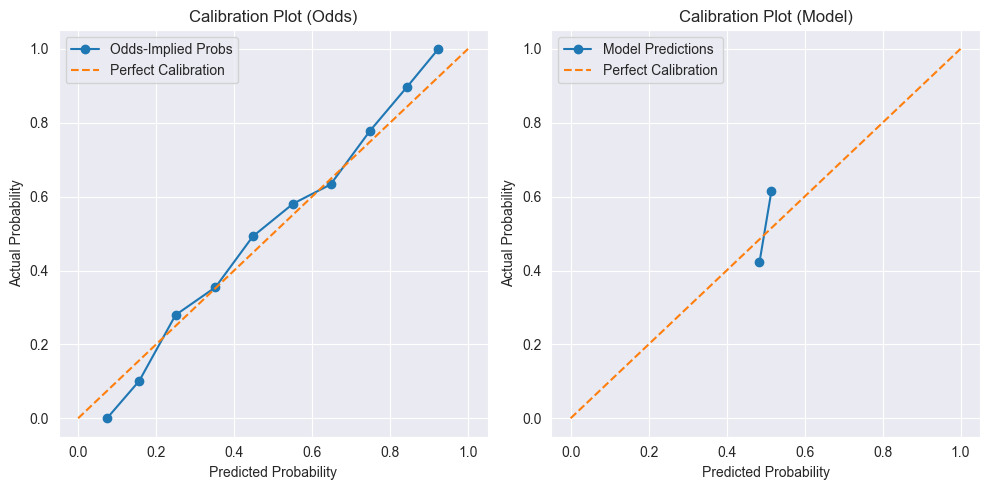

In [17]:
reset_seeds(42)

config = {
    'batch_size': 512,
    'dropout': np.float64(0.36826214072757374),
    'hidden_layer_sizes': [64, 32, 16],
    'learning_rate': np.float64(5.975027999960295e-06),
    'weight_decay': np.float64(2.1137059440645735e-05),
    'epochs': 50,
}

train_loader, val_loader, test_loader, _ = prepare_dataloaders(
    train_matches, 
    val_matches,
    player1_cols, 
    player2_cols, 
    env_cols, 
    batch_size=512,
    test_fold=test_matches
)
model = SymmetricNNWithoutEmbeddings(
    player_feature_size=player1_train.shape[1],
    env_feature_size=env_train.shape[1],
    hidden_sizes=config['hidden_layer_sizes'],
    dropout=config['dropout']
)

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

model.apply(initialize_weights)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)

criterion = nn.BCELoss()

best_val_brier = float('inf')
best_epoch = 0
for epoch in range(config['epochs']):
    model.train()
    epoch_loss = 0.0
    for p1, p2, env, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(p1, p2, env)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    cpu_rng_state = torch.get_rng_state()

    model.eval()
    val_predictions, val_y_true,  val_uncertainty = [], [], []

    with torch.no_grad():
        for p1, p2, env, labels, unc in val_loader:
            predictions = model(p1, p2, env)
            val_predictions.extend(predictions.tolist())
            val_y_true.extend(labels.tolist())
            val_uncertainty.extend(unc.tolist())

      
    val_y_true = np.array(val_y_true).ravel()
    val_predictions = np.array(val_predictions).ravel()

    brier = brier_score_loss(val_y_true, val_predictions)
    print(f"Epoch {epoch + 1}: Validation Brier Score: {brier:.4f}")
    scheduler.step(brier)

    if brier < best_val_brier:
        best_val_brier = brier
        best_epoch = epoch
    torch.set_rng_state(cpu_rng_state)

print(f"Best epoch: {best_epoch + 1}, Best Validation Brier: {best_val_brier:.4f}")


test_predictions, test_y_true, test_avgW, test_avgL, test_uncertainty = [], [], [], [], []

with torch.no_grad():
    for p1, p2, env, labels, unc, player1_rank, player2_rank, avgW, avgL, _ in test_loader:
        predictions = model(p1, p2, env)
        test_predictions.extend(predictions.tolist())
        test_y_true.extend(labels.tolist())
        test_avgW.extend(avgW.tolist())
        test_avgL.extend(avgL.tolist())
        test_uncertainty.extend(unc.tolist())

test_predictions = np.array(test_predictions).ravel()
test_y_true = np.array(test_y_true).ravel()
test_uncertainty = np.array(test_uncertainty)

unc_threshold = np.percentile(test_uncertainty, 50)
mask = test_uncertainty <= unc_threshold

filtered_predictions = test_predictions[mask]
filtered_labels = test_y_true[mask]
filtered_avgW = np.array(test_avgW)[mask]
filtered_avgL = np.array(test_avgL)[mask]

filtered_probW = 1 / filtered_avgW
filtered_probL = 1 / filtered_avgL
filtered_total_prob = filtered_probW + filtered_probL
filtered_probW /= filtered_total_prob
filtered_probW = np.where(np.isnan(filtered_probW), 0.5, filtered_probW)

filtered_brier_odds = brier_score_loss(filtered_labels, filtered_probW)
filtered_brier_model = brier_score_loss(filtered_labels, filtered_predictions)

print(f"Filtered Brier Score (Odds): {filtered_brier_odds:.4f}")
print(f"Filtered Brier Score (Model): {filtered_brier_model:.4f}")

prob_true_odds, prob_pred_odds = calibration_curve(filtered_labels, filtered_probW, n_bins=10)
prob_true_model, prob_pred_model = calibration_curve(filtered_labels, filtered_predictions, n_bins=10)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(prob_pred_odds, prob_true_odds, marker='o', label='Odds-Implied Probs')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Calibration Plot (Odds)')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(prob_pred_model, prob_true_model, marker='o', label='Model Predictions')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Calibration Plot (Model)')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()

plt.tight_layout()
plt.show()


In [51]:
from copy import deepcopy
def train_and_evaluate(params, train_matches, val_matches):

    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
    player1_cols = params['player1_cols']
    player2_cols = params['player2_cols']
    env_cols = params['env_cols']
    epochs = params['epochs']
   
   
    train_loader, val_loader = prepare_dataloaders(
        train_matches, 
        val_matches,
        player1_cols, 
        player2_cols, 
        env_cols, 
        batch_size=batch_size,
    )    
    model = SymmetricNNWithoutEmbeddings(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout
    )
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)

    criterion = nn.BCELoss()
    
    best_epoch_brier_score = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        cpu_rng_state = torch.get_rng_state()
        model.eval()
        val_preds, val_truth = [], []
        with torch.no_grad():
            for p1, p2, env, labels, unc in val_loader:
                preds = model(p1, p2, env)
                val_preds.extend(preds.squeeze().tolist())
                val_truth.extend(labels.squeeze().tolist())

        brier = brier_score_loss(np.array(val_truth), np.array(val_preds))
        scheduler.step(brier)
        if brier < best_epoch_brier_score:
            best_epoch_brier_score = brier
            best_model_state = deepcopy(model.state_dict())
        torch.set_rng_state(cpu_rng_state)
        
          
    best_model = SymmetricNNWithoutEmbeddings(
        player_feature_size=len(player1_cols),
        env_feature_size=len(env_cols),
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout
    )    
    best_model.load_state_dict(best_model_state)
    return best_epoch_brier_score, best_model

In [57]:
import os
import optuna
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)
reset_seeds(42)

hidden_layer_options = {
    0: [1024],
    1: [512, 256],
    2: [1024, 512],
    3: [512, 256, 128],
    4: [128, 64, 32],
    5: [512],
    6: [256],
    7: [128],
    8: [64, 32, 16],
    9: [128, 64],
}
best_score = float("inf")
best_model = None

def objective(trial):
    global best_model, best_score
    reset_seeds(42)

 
    hidden_layer_key = trial.suggest_categorical("hidden_layers", [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  
    dropout = trial.suggest_float("dropout", 0.05, 0.4)
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024])
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    hyperparams = dict(
        player1_cols=player1_cols,
        player2_cols=player2_cols,
        env_cols=env_cols,
        hidden_sizes=hidden_layers,
        dropout=dropout,
        learning_rate=lr,
        weight_decay=weight_decay,
        optimizer=optimizer,
        batch_size=batch_size,
        epochs=50,
    )
    
    score, model = train_and_evaluate(hyperparams, train_matches, val_matches)

    if score < best_score:
        best_score = score
        best_model = model

    return score
    

study = optuna.create_study(direction="minimize", study_name="not_nested_study", storage="sqlite:///optuna_study.db", sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=1)

print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2025-01-22 00:04:06,217] A new study created in RDB with name: not_nested_study
[I 2025-01-22 00:04:19,045] Trial 0 finished with value: 0.22498959469030402 and parameters: {'hidden_layers': 1, 'dropout': 0.05720457300353086, 'lr': 0.0008123245085588687, 'weight_decay': 4.6225890010208326e-05, 'batch_size': 512, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.22498959469030402.
[I 2025-01-22 00:05:01,653] Trial 1 finished with value: 0.20757167948248087 and parameters: {'hidden_layers': 3, 'dropout': 0.07276805754484783, 'lr': 0.0007025166339242157, 'weight_decay': 8.536189862866841e-05, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.20757167948248087.
[I 2025-01-22 00:05:11,297] Trial 2 finished with value: 0.20773918452615467 and parameters: {'hidden_layers': 6, 'dropout': 0.2592649925838798, 'lr': 0.0005829384542994739, 'weight_decay': 1.5030900645056814e-06, 'batch_size': 1024, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.20757167948248087.

Best parameters: {'hidden_layers': 7, 'dropout': 0.06846618855309827, 'lr': 0.0007983751163713626, 'weight_decay': 2.1257468824042613e-05, 'batch_size': 256, 'optimizer': 'Adam'}
Best score: 0.20727885267238835


In [58]:
import optuna
study = optuna.load_study(study_name="not_nested_study", storage="sqlite:///optuna_study.db")

In [59]:
import plotly.io as pio
fig=optuna.visualization.plot_param_importances(study)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)

pio.write_image(fig, "wykresy/param_importance_not_nested.pdf", format="pdf", scale=3) 

fig.show()

In [60]:
import plotly.io as pio
fig=optuna.visualization.plot_optimization_history(study)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)

pio.write_image(fig, "wykresy/optimization_history_not_nested.pdf", format="pdf", scale=3)  

fig.show()

In [68]:
import plotly.io as pio
fig=optuna.visualization.plot_slice(study, params=["batch_size", "lr", "hidden_layers", "optimizer", "dropout"])
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)

pio.write_image(fig, "wykresy/plot_slice_not_nested.pdf", format="pdf", scale=3) 

fig.show()

In [11]:
fig=optuna.visualization.plot_contour(study)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)

pio.write_image(fig, "wykresy/plot_contour_coordinate_not_nested.pdf", format="pdf", scale=3) 

fig.show()

In [12]:
fig=optuna.visualization.plot_rank(study)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)


pio.write_image(fig, "wykresy/plot_rank_not_nested.pdf", format="pdf", scale=3)  

fig.show()

In [70]:
def year_based_cv(df, start_year, end_year, year_col="year"):
    all_years = sorted(df[year_col].unique())
    all_years = [y for y in all_years if (y >= start_year and y <= end_year)]
    
    for i in range(0, len(all_years) - 1):
        train_years = all_years[:i+1]
        val_year = all_years[i+1]
        
        train_idx = df.index[df[year_col].isin(train_years)]
        val_idx   = df.index[df[year_col] == val_year]
        yield (train_idx, val_idx)


In [81]:
def run_cv(train_data,  hyperparams, start_year=2018, end_year=2022):
    scores = []
    for fold, (train_idx, val_idx) in enumerate(year_based_cv(train_data, start_year, end_year), 1):
        print(f"Fold {fold}")
        reset_seeds(42)
        train_fold = train_data.loc[train_idx]
        val_fold   = train_data.loc[val_idx]
        fold_score, _ = train_and_evaluate(hyperparams, train_fold, val_fold)
        print(f"Fold {fold} best brier: {fold_score:.4f}")
        scores.append(fold_score)
    return np.mean(scores)

In [84]:
import optuna
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)  
reset_seeds(42)
hidden_layer_options = {
    0: [1024],
    1: [512, 256],
    2: [1024, 512],
    3: [512, 256, 128],
    4: [128, 64, 32],
    5: [512],
    6: [256],
    7: [128],
    8: [64, 32, 16],
    9: [128, 64],
}

def objective(trial):
    reset_seeds(42)


    hidden_layer_key = trial.suggest_categorical("hidden_layers", [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  
    dropout = trial.suggest_float("dropout", 0.05, 0.4)
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024])
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])

    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    hyperparams = dict(
        player1_cols=player1_cols,
        player2_cols=player2_cols,
        env_cols=env_cols,
        hidden_sizes=hidden_layers,
        dropout=dropout,
        learning_rate=lr,
        weight_decay=weight_decay,
        batch_size=batch_size,
        optimizer=optimizer,
        epochs=50,
    )
    
    score = run_cv(train_matches_nested,hyperparams,  2018, 2022)
    return score
    

study2 = optuna.create_study(direction="minimize", study_name="my_study8", storage="sqlite:///optuna_study.db", sampler=sampler)
study2.optimize(objective, n_trials=100, n_jobs=1)

print("Best parameters:", study2.best_params)
print("Best score:", study2.best_value)


[I 2025-01-22 02:19:03,095] A new study created in RDB with name: my_study8


Fold 1
Fold 1 best brier: 0.2428
Fold 2
Fold 2 best brier: 0.2344
Fold 3
Fold 3 best brier: 0.2323
Fold 4
Fold 4 best brier: 0.2250


[I 2025-01-22 02:19:37,136] Trial 0 finished with value: 0.2336068714093516 and parameters: {'hidden_layers': 1, 'dropout': 0.05720457300353086, 'lr': 0.0008123245085588687, 'weight_decay': 4.6225890010208326e-05, 'batch_size': 512, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.2336068714093516.


Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2152
Fold 4
Fold 4 best brier: 0.2076


[I 2025-01-22 02:21:26,609] Trial 1 finished with value: 0.21424168253522452 and parameters: {'hidden_layers': 3, 'dropout': 0.07276805754484783, 'lr': 0.0007025166339242157, 'weight_decay': 8.536189862866841e-05, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2226
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 02:21:51,609] Trial 2 finished with value: 0.21444688764087305 and parameters: {'hidden_layers': 6, 'dropout': 0.2592649925838798, 'lr': 0.0005829384542994739, 'weight_decay': 1.5030900645056814e-06, 'batch_size': 1024, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2515
Fold 2
Fold 2 best brier: 0.2507
Fold 3
Fold 3 best brier: 0.2504
Fold 4
Fold 4 best brier: 0.2506


[I 2025-01-22 02:22:56,358] Trial 3 finished with value: 0.25080200690472215 and parameters: {'hidden_layers': 3, 'dropout': 0.319944621340081, 'lr': 1.6677615430197902e-06, 'weight_decay': 5.211124595788262e-06, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2426
Fold 2
Fold 2 best brier: 0.2359
Fold 3
Fold 3 best brier: 0.2344
Fold 4
Fold 4 best brier: 0.2291


[I 2025-01-22 02:23:29,893] Trial 4 finished with value: 0.23549355204825032 and parameters: {'hidden_layers': 0, 'dropout': 0.05889669436043332, 'lr': 2.107047280657824e-06, 'weight_decay': 1.1557352816269873e-06, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2215
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 02:24:21,552] Trial 5 finished with value: 0.21437271881514222 and parameters: {'hidden_layers': 2, 'dropout': 0.3326040543074219, 'lr': 0.00048783606034521424, 'weight_decay': 4.32520752538653e-06, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2459
Fold 2
Fold 2 best brier: 0.2412
Fold 3
Fold 3 best brier: 0.2410
Fold 4
Fold 4 best brier: 0.2378


[I 2025-01-22 02:24:46,041] Trial 6 finished with value: 0.24148101721553206 and parameters: {'hidden_layers': 7, 'dropout': 0.22403697706233494, 'lr': 7.991621920384356e-06, 'weight_decay': 3.7126241790405305e-06, 'batch_size': 1024, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2405
Fold 2
Fold 2 best brier: 0.2328
Fold 3
Fold 3 best brier: 0.2313
Fold 4
Fold 4 best brier: 0.2259


[I 2025-01-22 02:25:19,260] Trial 7 finished with value: 0.23261595239666832 and parameters: {'hidden_layers': 0, 'dropout': 0.08160141951904291, 'lr': 0.00032055863990707473, 'weight_decay': 4.38086761972579e-06, 'batch_size': 256, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2146
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2083


[I 2025-01-22 02:26:16,608] Trial 8 finished with value: 0.21475326146202628 and parameters: {'hidden_layers': 2, 'dropout': 0.33602777007042556, 'lr': 4.630228617122102e-05, 'weight_decay': 1.1463075602213993e-05, 'batch_size': 256, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2447
Fold 2
Fold 2 best brier: 0.2379
Fold 3
Fold 3 best brier: 0.2363
Fold 4
Fold 4 best brier: 0.2304


[I 2025-01-22 02:26:46,166] Trial 9 finished with value: 0.23732063255674413 and parameters: {'hidden_layers': 5, 'dropout': 0.05177155434617654, 'lr': 3.0368556852449663e-06, 'weight_decay': 1.251605833757037e-05, 'batch_size': 256, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2220
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 02:28:33,438] Trial 10 finished with value: 0.21452952690399119 and parameters: {'hidden_layers': 3, 'dropout': 0.1565696814235438, 'lr': 7.681567676706581e-05, 'weight_decay': 8.132381660836385e-05, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2222
Fold 2
Fold 2 best brier: 0.2143
Fold 3
Fold 3 best brier: 0.2154
Fold 4
Fold 4 best brier: 0.2087


[I 2025-01-22 02:29:53,689] Trial 11 finished with value: 0.21514430589167674 and parameters: {'hidden_layers': 9, 'dropout': 0.3864826672305982, 'lr': 0.00016823177373067748, 'weight_decay': 2.9978582191230595e-05, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 02:30:45,668] Trial 12 finished with value: 0.21439947792276332 and parameters: {'hidden_layers': 2, 'dropout': 0.15228346292569533, 'lr': 0.00016701448239690272, 'weight_decay': 2.0703137793829073e-05, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2398
Fold 2
Fold 2 best brier: 0.2282
Fold 3
Fold 3 best brier: 0.2271
Fold 4
Fold 4 best brier: 0.2205


[I 2025-01-22 02:31:24,048] Trial 13 finished with value: 0.22889416343826513 and parameters: {'hidden_layers': 8, 'dropout': 0.24320918402643174, 'lr': 1.9960199043477784e-05, 'weight_decay': 9.94333971176117e-05, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2225
Fold 2
Fold 2 best brier: 0.2143
Fold 3
Fold 3 best brier: 0.2153
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 02:31:52,350] Trial 14 finished with value: 0.21496426098854232 and parameters: {'hidden_layers': 4, 'dropout': 0.13419264275613083, 'lr': 0.0009663963487059749, 'weight_decay': 2.4135383329138787e-06, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21424168253522452.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 02:34:02,677] Trial 15 finished with value: 0.21389958970539552 and parameters: {'hidden_layers': 2, 'dropout': 0.2960446518364426, 'lr': 0.0002558817346703139, 'weight_decay': 6.989577855511048e-06, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.21389958970539552.


Fold 1
Fold 1 best brier: 0.2222
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 02:35:48,003] Trial 16 finished with value: 0.21455238915762256 and parameters: {'hidden_layers': 3, 'dropout': 0.20746996584534427, 'lr': 0.00023175012058735005, 'weight_decay': 8.532948298390373e-06, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.21389958970539552.


Fold 1
Fold 1 best brier: 0.2263
Fold 2
Fold 2 best brier: 0.2167
Fold 3
Fold 3 best brier: 0.2164
Fold 4
Fold 4 best brier: 0.2096


[I 2025-01-22 02:37:13,560] Trial 17 finished with value: 0.21724617842509414 and parameters: {'hidden_layers': 8, 'dropout': 0.28981009445806305, 'lr': 7.759288538761896e-05, 'weight_decay': 2.0799706636213565e-05, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.21389958970539552.


Fold 1
Fold 1 best brier: 0.2253
Fold 2
Fold 2 best brier: 0.2175
Fold 3
Fold 3 best brier: 0.2161
Fold 4
Fold 4 best brier: 0.2101


[I 2025-01-22 02:38:18,117] Trial 18 finished with value: 0.21723613468891836 and parameters: {'hidden_layers': 6, 'dropout': 0.193852031580611, 'lr': 1.5469327173781625e-05, 'weight_decay': 5.319301949684405e-05, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.21389958970539552.


Fold 1
Fold 1 best brier: 0.2228
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2150
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 02:38:54,030] Trial 19 finished with value: 0.2149324025357353 and parameters: {'hidden_layers': 9, 'dropout': 0.11176752958466395, 'lr': 0.00010262076315685176, 'weight_decay': 7.429118755525644e-06, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.21389958970539552.


Fold 1
Fold 1 best brier: 0.2221
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2147
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 02:39:34,909] Trial 20 finished with value: 0.21445952090757342 and parameters: {'hidden_layers': 7, 'dropout': 0.3801322904543982, 'lr': 0.0003800288340932761, 'weight_decay': 1.6533081668199183e-05, 'batch_size': 64, 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.21389958970539552.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 02:40:25,677] Trial 21 finished with value: 0.214199685242006 and parameters: {'hidden_layers': 2, 'dropout': 0.32378076404387746, 'lr': 0.0004866328043176988, 'weight_decay': 2.790631500274693e-06, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.21389958970539552.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2120
Fold 3
Fold 3 best brier: 0.2140
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 02:42:38,482] Trial 22 finished with value: 0.21368987173316445 and parameters: {'hidden_layers': 2, 'dropout': 0.28372735735443244, 'lr': 0.0003047958757168667, 'weight_decay': 2.0104714998447313e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 02:44:51,251] Trial 23 finished with value: 0.2138197831675927 and parameters: {'hidden_layers': 2, 'dropout': 0.29267740593464314, 'lr': 0.00024310785656703687, 'weight_decay': 2.3862848336183957e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2140
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 02:47:03,644] Trial 24 finished with value: 0.21463443979368824 and parameters: {'hidden_layers': 2, 'dropout': 0.2872474616470849, 'lr': 3.9065258915461526e-05, 'weight_decay': 1.9520565816400938e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 02:49:15,993] Trial 25 finished with value: 0.21413256990859544 and parameters: {'hidden_layers': 2, 'dropout': 0.2854916675862129, 'lr': 0.0001302066686752924, 'weight_decay': 1.0191471147405445e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 02:51:28,206] Trial 26 finished with value: 0.2141145313690812 and parameters: {'hidden_layers': 2, 'dropout': 0.35559984998265537, 'lr': 0.0002245919875992188, 'weight_decay': 1.7690313228849517e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2480
Fold 2
Fold 2 best brier: 0.2439
Fold 3
Fold 3 best brier: 0.2423
Fold 4
Fold 4 best brier: 0.2384


[I 2025-01-22 02:52:48,940] Trial 27 finished with value: 0.24316001472634213 and parameters: {'hidden_layers': 4, 'dropout': 0.2993131083869251, 'lr': 5.980983326107156e-05, 'weight_decay': 6.302392844980966e-06, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 02:54:22,062] Trial 28 finished with value: 0.21390131613812874 and parameters: {'hidden_layers': 1, 'dropout': 0.2613345641624555, 'lr': 0.00026998606496476995, 'weight_decay': 3.0638123267666015e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2504
Fold 2
Fold 2 best brier: 0.2489
Fold 3
Fold 3 best brier: 0.2483
Fold 4
Fold 4 best brier: 0.2463


[I 2025-01-22 02:54:55,896] Trial 29 finished with value: 0.24847394937828515 and parameters: {'hidden_layers': 5, 'dropout': 0.2628473373698967, 'lr': 2.032746404423549e-05, 'weight_decay': 1.4083717267584048e-06, 'batch_size': 128, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2147
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 02:55:56,519] Trial 30 finished with value: 0.21424362967426042 and parameters: {'hidden_layers': 1, 'dropout': 0.3580091821529411, 'lr': 0.000978995286196872, 'weight_decay': 2.1361987802169825e-06, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 02:57:29,320] Trial 31 finished with value: 0.21395538454222612 and parameters: {'hidden_layers': 1, 'dropout': 0.26100840111676954, 'lr': 0.0002841444414998415, 'weight_decay': 3.102859284722316e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 02:59:01,732] Trial 32 finished with value: 0.214283498419726 and parameters: {'hidden_layers': 1, 'dropout': 0.23873975566538236, 'lr': 0.00013197716228885241, 'weight_decay': 3.112871044984534e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2147
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 02:59:33,311] Trial 33 finished with value: 0.21403966084796275 and parameters: {'hidden_layers': 1, 'dropout': 0.30566520202107683, 'lr': 0.0006706419255157682, 'weight_decay': 6.379698120168491e-06, 'batch_size': 1024, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2121
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 03:01:46,877] Trial 34 finished with value: 0.21378760355659462 and parameters: {'hidden_layers': 2, 'dropout': 0.27159342528075153, 'lr': 0.0003506750272637186, 'weight_decay': 1.3747310155122736e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2255
Fold 2
Fold 2 best brier: 0.2177
Fold 3
Fold 3 best brier: 0.2163
Fold 4
Fold 4 best brier: 0.2099


[I 2025-01-22 03:03:46,766] Trial 35 finished with value: 0.21732654189319672 and parameters: {'hidden_layers': 2, 'dropout': 0.2770646951222918, 'lr': 0.0004364823316480138, 'weight_decay': 1.2921621334393541e-06, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2147
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 03:06:00,000] Trial 36 finished with value: 0.21414914688099349 and parameters: {'hidden_layers': 2, 'dropout': 0.30840343269834103, 'lr': 0.0006389354044171188, 'weight_decay': 1.6834044131471308e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2221
Fold 2
Fold 2 best brier: 0.2139
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 03:06:49,511] Trial 37 finished with value: 0.2147552972751252 and parameters: {'hidden_layers': 2, 'dropout': 0.22154277680061898, 'lr': 0.00019592260328386155, 'weight_decay': 4.738128226892719e-06, 'batch_size': 1024, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 03:07:55,177] Trial 38 finished with value: 0.2140703036141075 and parameters: {'hidden_layers': 6, 'dropout': 0.19008672518024644, 'lr': 0.0001072053446474397, 'weight_decay': 1.0316551987906946e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2309
Fold 2
Fold 2 best brier: 0.2219
Fold 3
Fold 3 best brier: 0.2210
Fold 4
Fold 4 best brier: 0.2144


[I 2025-01-22 03:09:16,355] Trial 39 finished with value: 0.22207180875463353 and parameters: {'hidden_layers': 2, 'dropout': 0.35092268482360633, 'lr': 0.00036546822690900155, 'weight_decay': 2.3576842500950004e-06, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2072


[I 2025-01-22 03:10:31,955] Trial 40 finished with value: 0.21376778333973845 and parameters: {'hidden_layers': 0, 'dropout': 0.24620853185547917, 'lr': 0.0006135769741673605, 'weight_decay': 3.7765769850165746e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:11:47,322] Trial 41 finished with value: 0.2137721554042297 and parameters: {'hidden_layers': 0, 'dropout': 0.24531911689147493, 'lr': 0.0005984428897936098, 'weight_decay': 4.263556309618967e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 03:13:02,577] Trial 42 finished with value: 0.2139252872211425 and parameters: {'hidden_layers': 0, 'dropout': 0.244996320134375, 'lr': 0.0006783852966891356, 'weight_decay': 3.8230715663780395e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2076


[I 2025-01-22 03:14:17,855] Trial 43 finished with value: 0.2137752338853259 and parameters: {'hidden_layers': 0, 'dropout': 0.2740522755091696, 'lr': 0.0005407395013965743, 'weight_decay': 1.4934095891846467e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2220
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2076


[I 2025-01-22 03:14:51,033] Trial 44 finished with value: 0.2141572748204451 and parameters: {'hidden_layers': 0, 'dropout': 0.27345846405004615, 'lr': 0.00047015744071989257, 'weight_decay': 1.4896871009482889e-06, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:16:06,688] Trial 45 finished with value: 0.2138261525551604 and parameters: {'hidden_layers': 0, 'dropout': 0.2315235150670538, 'lr': 0.0008358580777759516, 'weight_decay': 3.853439011248237e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:17:22,110] Trial 46 finished with value: 0.2139079163233479 and parameters: {'hidden_layers': 0, 'dropout': 0.21184196517531015, 'lr': 0.0005586880949263754, 'weight_decay': 1.2366844689022503e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2229
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 03:17:53,743] Trial 47 finished with value: 0.21454993821169022 and parameters: {'hidden_layers': 0, 'dropout': 0.2462382532795635, 'lr': 0.0003469594698299255, 'weight_decay': 5.373356032409684e-06, 'batch_size': 1024, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2419
Fold 2
Fold 2 best brier: 0.2346
Fold 3
Fold 3 best brier: 0.2330
Fold 4
Fold 4 best brier: 0.2273


[I 2025-01-22 03:18:27,543] Trial 48 finished with value: 0.2341987157174906 and parameters: {'hidden_layers': 0, 'dropout': 0.18752258221320645, 'lr': 2.601309249667389e-06, 'weight_decay': 1.6677860980203092e-06, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2306
Fold 2
Fold 2 best brier: 0.2215
Fold 3
Fold 3 best brier: 0.2201
Fold 4
Fold 4 best brier: 0.2137


[I 2025-01-22 03:19:07,021] Trial 49 finished with value: 0.22147798676592334 and parameters: {'hidden_layers': 0, 'dropout': 0.17181759639582064, 'lr': 6.97675723027801e-06, 'weight_decay': 2.010982207998919e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2223
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 03:19:32,231] Trial 50 finished with value: 0.21456484035909107 and parameters: {'hidden_layers': 7, 'dropout': 0.31629363206734473, 'lr': 0.0007676736632017335, 'weight_decay': 2.8045988745224827e-06, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:20:47,586] Trial 51 finished with value: 0.21381656475530111 and parameters: {'hidden_layers': 0, 'dropout': 0.27223431526515485, 'lr': 0.0004973558178710102, 'weight_decay': 1.5571403797858195e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2076


[I 2025-01-22 03:22:03,040] Trial 52 finished with value: 0.21386301761213167 and parameters: {'hidden_layers': 0, 'dropout': 0.27227637297221113, 'lr': 0.0005645454314145129, 'weight_decay': 1.4775167512378838e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:23:18,396] Trial 53 finished with value: 0.21385562553942492 and parameters: {'hidden_layers': 0, 'dropout': 0.250065040096843, 'lr': 0.00033167794212981714, 'weight_decay': 1.1520434573444425e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2074


[I 2025-01-22 03:24:33,760] Trial 54 finished with value: 0.21381971289247031 and parameters: {'hidden_layers': 0, 'dropout': 0.22434207810206225, 'lr': 0.0004333473044346829, 'weight_decay': 1.7413617670787142e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2229
Fold 2
Fold 2 best brier: 0.2139
Fold 3
Fold 3 best brier: 0.2154
Fold 4
Fold 4 best brier: 0.2083


[I 2025-01-22 03:26:03,171] Trial 55 finished with value: 0.21512058025963074 and parameters: {'hidden_layers': 8, 'dropout': 0.3362158440093193, 'lr': 0.0009825123906848983, 'weight_decay': 1.0916055537315739e-05, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2224
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 03:27:21,815] Trial 56 finished with value: 0.21458845261788878 and parameters: {'hidden_layers': 9, 'dropout': 0.20571351154843792, 'lr': 0.00017968515098134219, 'weight_decay': 2.4299866843119068e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2216
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2152
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 03:29:12,051] Trial 57 finished with value: 0.21441929517447983 and parameters: {'hidden_layers': 3, 'dropout': 0.2752453594528207, 'lr': 0.0005695022460041523, 'weight_decay': 8.942936526822672e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2452
Fold 2
Fold 2 best brier: 0.2379
Fold 3
Fold 3 best brier: 0.2361
Fold 4
Fold 4 best brier: 0.2301


[I 2025-01-22 03:29:58,406] Trial 58 finished with value: 0.23729747760822154 and parameters: {'hidden_layers': 5, 'dropout': 0.23284124273698453, 'lr': 1.2974747448921698e-06, 'weight_decay': 3.567477542416067e-06, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2256
Fold 2
Fold 2 best brier: 0.2179
Fold 3
Fold 3 best brier: 0.2174
Fold 4
Fold 4 best brier: 0.2106


[I 2025-01-22 03:31:19,393] Trial 59 finished with value: 0.21786325009723673 and parameters: {'hidden_layers': 4, 'dropout': 0.2595134598568167, 'lr': 0.0008089221125967271, 'weight_decay': 2.142064025328839e-06, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2222
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:31:51,504] Trial 60 finished with value: 0.21425528135213387 and parameters: {'hidden_layers': 0, 'dropout': 0.3258072129194004, 'lr': 0.0004067057634261952, 'weight_decay': 5.399162090301498e-06, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2073


[I 2025-01-22 03:33:06,804] Trial 61 finished with value: 0.21388540477744172 and parameters: {'hidden_layers': 0, 'dropout': 0.22031181541575312, 'lr': 0.00045501705536780414, 'weight_decay': 1.7428055066190129e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2140
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:34:22,358] Trial 62 finished with value: 0.21384057518117064 and parameters: {'hidden_layers': 0, 'dropout': 0.2826119357681119, 'lr': 0.0003138930862529754, 'weight_decay': 1.430628018425984e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2215
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2076


[I 2025-01-22 03:35:37,679] Trial 63 finished with value: 0.21402248254063153 and parameters: {'hidden_layers': 0, 'dropout': 0.24698839433227923, 'lr': 0.000146624663360493, 'weight_decay': 1.8447240296022346e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 03:36:42,967] Trial 64 finished with value: 0.21408837995176358 and parameters: {'hidden_layers': 6, 'dropout': 0.2687677603594424, 'lr': 0.00021204387509144042, 'weight_decay': 1.1238687580529179e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 03:37:58,166] Trial 65 finished with value: 0.21388326087225026 and parameters: {'hidden_layers': 0, 'dropout': 0.2541329612489894, 'lr': 0.0005289481420989828, 'weight_decay': 2.7204719383295086e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2223
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 03:38:30,563] Trial 66 finished with value: 0.2145037486954392 and parameters: {'hidden_layers': 7, 'dropout': 0.2981501145691695, 'lr': 0.00028012611603129726, 'weight_decay': 1.6147320553935096e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2229
Fold 2
Fold 2 best brier: 0.2136
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 03:39:00,031] Trial 67 finished with value: 0.21483869853564203 and parameters: {'hidden_layers': 8, 'dropout': 0.2304122186626306, 'lr': 0.0007418972002660477, 'weight_decay': 1.3084726829148969e-06, 'batch_size': 256, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2216
Fold 2
Fold 2 best brier: 0.2124
Fold 3
Fold 3 best brier: 0.2151
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 03:40:50,306] Trial 68 finished with value: 0.2142817245286908 and parameters: {'hidden_layers': 3, 'dropout': 0.20328305846387093, 'lr': 0.0004085726526151297, 'weight_decay': 2.167008236890025e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2403
Fold 2
Fold 2 best brier: 0.2301
Fold 3
Fold 3 best brier: 0.2277
Fold 4
Fold 4 best brier: 0.2201


[I 2025-01-22 03:42:08,578] Trial 69 finished with value: 0.22957488448924357 and parameters: {'hidden_layers': 9, 'dropout': 0.3095430709208342, 'lr': 4.927872920489313e-06, 'weight_decay': 4.336776720767932e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2223
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 03:42:40,670] Trial 70 finished with value: 0.21431057879738283 and parameters: {'hidden_layers': 0, 'dropout': 0.21695357108143687, 'lr': 0.0006368691364989199, 'weight_decay': 3.5529895893759504e-06, 'batch_size': 1024, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 03:44:53,577] Trial 71 finished with value: 0.21403265469499927 and parameters: {'hidden_layers': 2, 'dropout': 0.2931729413251539, 'lr': 0.0003489860523935668, 'weight_decay': 2.5356217778611577e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2203
Fold 2
Fold 2 best brier: 0.2124
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 03:47:06,509] Trial 72 finished with value: 0.2137981062276985 and parameters: {'hidden_layers': 2, 'dropout': 0.2864700371732355, 'lr': 0.00027946001120656447, 'weight_decay': 1.9569524800225714e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 03:49:19,440] Trial 73 finished with value: 0.2142456559291858 and parameters: {'hidden_layers': 2, 'dropout': 0.26532942963755257, 'lr': 0.0004803686884313199, 'weight_decay': 1.9718443543787157e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2216
Fold 2
Fold 2 best brier: 0.2126
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 03:50:27,961] Trial 74 finished with value: 0.21406158105516912 and parameters: {'hidden_layers': 5, 'dropout': 0.25636416871140116, 'lr': 0.00024178355418200898, 'weight_decay': 1.3645213413205967e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2276
Fold 2
Fold 2 best brier: 0.2197
Fold 3
Fold 3 best brier: 0.2182
Fold 4
Fold 4 best brier: 0.2117


[I 2025-01-22 03:52:27,047] Trial 75 finished with value: 0.2193365609651789 and parameters: {'hidden_layers': 2, 'dropout': 0.2822994528397609, 'lr': 0.00027448143862692447, 'weight_decay': 1.0348967468720222e-06, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2144
Fold 3
Fold 3 best brier: 0.2156
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 03:53:58,295] Trial 76 finished with value: 0.2148655648997415 and parameters: {'hidden_layers': 4, 'dropout': 0.08926927365853926, 'lr': 0.00084573439047846, 'weight_decay': 1.5861832019430891e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2140
Fold 4
Fold 4 best brier: 0.2076


[I 2025-01-22 03:55:10,854] Trial 77 finished with value: 0.21413690190414378 and parameters: {'hidden_layers': 0, 'dropout': 0.23787209110410856, 'lr': 9.061388621533872e-05, 'weight_decay': 3.2792741947046525e-06, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 03:57:22,896] Trial 78 finished with value: 0.21408462563761738 and parameters: {'hidden_layers': 2, 'dropout': 0.30220607996331345, 'lr': 0.00015395574663987325, 'weight_decay': 3.223369078472491e-05, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2229
Fold 2
Fold 2 best brier: 0.2151
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 03:58:13,694] Trial 79 finished with value: 0.21505542689486282 and parameters: {'hidden_layers': 0, 'dropout': 0.28213585851642037, 'lr': 2.808166200144404e-05, 'weight_decay': 1.366841424594186e-05, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 03:59:04,654] Trial 80 finished with value: 0.2143461920880258 and parameters: {'hidden_layers': 2, 'dropout': 0.22648090598459575, 'lr': 0.00037671503817256327, 'weight_decay': 1.8397750632485699e-06, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2147
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 04:01:17,688] Trial 81 finished with value: 0.21391396005257976 and parameters: {'hidden_layers': 2, 'dropout': 0.29393094393309616, 'lr': 0.00030361770423157383, 'weight_decay': 2.2808780675721905e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2204
Fold 2
Fold 2 best brier: 0.2126
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 04:03:31,174] Trial 82 finished with value: 0.21381858519080518 and parameters: {'hidden_layers': 2, 'dropout': 0.2700175879111801, 'lr': 0.00020160077492587864, 'weight_decay': 2.599157132993057e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2126
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 04:05:53,793] Trial 83 finished with value: 0.21399265623634772 and parameters: {'hidden_layers': 2, 'dropout': 0.24002104562612667, 'lr': 0.0004942376436002618, 'weight_decay': 1.2218568280597224e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 04:06:59,135] Trial 84 finished with value: 0.2141767092381091 and parameters: {'hidden_layers': 6, 'dropout': 0.2541035257123553, 'lr': 0.00021455221208260244, 'weight_decay': 2.7938768793322734e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 04:09:12,143] Trial 85 finished with value: 0.21391346628384333 and parameters: {'hidden_layers': 2, 'dropout': 0.2715760665076014, 'lr': 0.0004108924363052004, 'weight_decay': 4.843217759995027e-06, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2074


[I 2025-01-22 04:09:51,625] Trial 86 finished with value: 0.21375863910918308 and parameters: {'hidden_layers': 0, 'dropout': 0.2638996816652349, 'lr': 0.0006298439512215922, 'weight_decay': 2.0169434811216265e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2074


[I 2025-01-22 04:10:31,202] Trial 87 finished with value: 0.21380475237437035 and parameters: {'hidden_layers': 0, 'dropout': 0.3131440544689686, 'lr': 0.0006381148550827668, 'weight_decay': 2.0454101050195475e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2308
Fold 2
Fold 2 best brier: 0.2228
Fold 3
Fold 3 best brier: 0.2217
Fold 4
Fold 4 best brier: 0.2160


[I 2025-01-22 04:11:09,011] Trial 88 finished with value: 0.2228251135897083 and parameters: {'hidden_layers': 0, 'dropout': 0.3179598335123607, 'lr': 0.0006624537260600007, 'weight_decay': 2.047557307487152e-06, 'batch_size': 128, 'optimizer': 'SGD'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2074


[I 2025-01-22 04:11:48,355] Trial 89 finished with value: 0.21383716265838054 and parameters: {'hidden_layers': 0, 'dropout': 0.33476187285213954, 'lr': 0.0005861996760529068, 'weight_decay': 1.3870732366327865e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2072


[I 2025-01-22 04:12:27,253] Trial 90 finished with value: 0.21377574252493975 and parameters: {'hidden_layers': 0, 'dropout': 0.34438881573167657, 'lr': 0.0008634803336808434, 'weight_decay': 1.530838408931002e-06, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2124
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2072


[I 2025-01-22 04:13:06,207] Trial 91 finished with value: 0.2138871696062585 and parameters: {'hidden_layers': 0, 'dropout': 0.3442250281034867, 'lr': 0.000884247235948124, 'weight_decay': 1.5344278120414095e-06, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2072


[I 2025-01-22 04:13:44,894] Trial 92 finished with value: 0.21387101318839358 and parameters: {'hidden_layers': 0, 'dropout': 0.37266495238645814, 'lr': 0.0007569678951276604, 'weight_decay': 1.218928575495011e-06, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2074


[I 2025-01-22 04:14:24,182] Trial 93 finished with value: 0.21391128683904903 and parameters: {'hidden_layers': 0, 'dropout': 0.3113854349800221, 'lr': 0.0009966252639697385, 'weight_decay': 1.8984889376041082e-06, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2126
Fold 3
Fold 3 best brier: 0.2140
Fold 4
Fold 4 best brier: 0.2074


[I 2025-01-22 04:15:03,803] Trial 94 finished with value: 0.21378164140381656 and parameters: {'hidden_layers': 0, 'dropout': 0.28889765776730825, 'lr': 0.0006534088967813224, 'weight_decay': 1.570064766546526e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2122
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2076


[I 2025-01-22 04:15:42,768] Trial 95 finished with value: 0.21386021703709862 and parameters: {'hidden_layers': 0, 'dropout': 0.28605857308061255, 'lr': 0.0006941942001251295, 'weight_decay': 2.2825789184059417e-06, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2221
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2147
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 04:16:14,913] Trial 96 finished with value: 0.21439030565402845 and parameters: {'hidden_layers': 7, 'dropout': 0.3213477686617928, 'lr': 0.0005829900214197955, 'weight_decay': 6.979902807790506e-05, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2075


[I 2025-01-22 04:16:54,562] Trial 97 finished with value: 0.21378269573513653 and parameters: {'hidden_layers': 0, 'dropout': 0.30554429605694516, 'lr': 0.000809213650837902, 'weight_decay': 3.0495670237260245e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2222
Fold 2
Fold 2 best brier: 0.2138
Fold 3
Fold 3 best brier: 0.2153
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 04:17:31,277] Trial 98 finished with value: 0.2148443815216785 and parameters: {'hidden_layers': 9, 'dropout': 0.3729548021075668, 'lr': 0.0008427035753969616, 'weight_decay': 5.86767773903954e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 04:18:22,053] Trial 99 finished with value: 0.21413096329168535 and parameters: {'hidden_layers': 3, 'dropout': 0.2790628208716839, 'lr': 0.0005168892485828086, 'weight_decay': 2.9927013088485684e-06, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21368987173316445.


Best parameters: {'hidden_layers': 2, 'dropout': 0.28372735735443244, 'lr': 0.0003047958757168667, 'weight_decay': 2.0104714998447313e-06, 'batch_size': 32, 'optimizer': 'Adam'}
Best score: 0.21368987173316445


In [85]:
import optuna
import plotly.io as pio
study2 = optuna.load_study(study_name="my_study8", storage="sqlite:///optuna_study.db")

In [86]:
fig=optuna.visualization.plot_param_importances(study2)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)


pio.write_image(fig, "wykresy/param_importance.pdf", format="pdf", scale=3)  

fig.show()

In [88]:
import plotly.io as pio
fig=optuna.visualization.plot_optimization_history(study2)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)


pio.write_image(fig, "wykresy/optimization_history2.pdf", format="pdf", scale=3)  

fig.show()

In [89]:
import plotly.io as pio
fig=optuna.visualization.plot_slice(study2)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)


pio.write_image(fig, "wykresy/plot_slice.pdf", format="pdf", scale=3)

fig.show()

In [90]:
import optuna
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import brier_score_loss
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)  
reset_seeds(42)
hidden_layer_options = {
    0: [1024],
    1: [512, 256],
    2: [1024, 512],
    3: [512, 256, 128],
    4: [128, 64, 32],
    5: [512],
    6: [256],
    7: [128],
    8: [64, 32, 16],
    9: [128, 64],
}

def objective(trial):
    reset_seeds(42)


    hidden_layer_key = trial.suggest_categorical("hidden_layers", [1, 2, 3])
  
    dropout = trial.suggest_float("dropout", 0.2, 0.3)
    lr = trial.suggest_float("lr", 0.0003, 0.0005, log=True)
    weight_decay = 2e-6
    batch_size = trial.suggest_categorical("batch_size", [32, 256, 512])
    optimizer = trial.suggest_categorical("optimizer", ["Adam"])

    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    hyperparams = dict(
        player1_cols=player1_cols,
        player2_cols=player2_cols,
        env_cols=env_cols,
        hidden_sizes=hidden_layers,
        dropout=dropout,
        learning_rate=lr,
        weight_decay=weight_decay,
        batch_size=batch_size,
        optimizer=optimizer,
        epochs=50,
    )
    
    score = run_cv(train_matches_nested,hyperparams,  2018, 2022)
    return score
    

study2 = optuna.create_study(direction="minimize", study_name="my_study9", storage="sqlite:///optuna_study.db", sampler=sampler)
study2.optimize(objective, n_trials=50, n_jobs=1)

print("Best parameters:", study2.best_params)
print("Best score:", study2.best_value)


[I 2025-01-22 13:41:02,729] A new study created in RDB with name: my_study9


Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 13:41:53,127] Trial 0 finished with value: 0.21432198686692536 and parameters: {'hidden_layers': 2, 'dropout': 0.25986584841970367, 'lr': 0.0003248880930569479, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.21432198686692536.


Fold 1
Fold 1 best brier: 0.2204
Fold 2
Fold 2 best brier: 0.2123
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 13:44:05,374] Trial 1 finished with value: 0.21375060404933582 and parameters: {'hidden_layers': 2, 'dropout': 0.29699098521619943, 'lr': 0.0004589840710632625, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 13:44:55,628] Trial 2 finished with value: 0.21431655149470105 and parameters: {'hidden_layers': 2, 'dropout': 0.2291229140198042, 'lr': 0.0004100719414494833, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2150
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 13:45:49,980] Trial 3 finished with value: 0.21427922517690734 and parameters: {'hidden_layers': 2, 'dropout': 0.25142344384136117, 'lr': 0.00040602024233352585, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2138
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 13:46:28,956] Trial 4 finished with value: 0.21449559739058208 and parameters: {'hidden_layers': 3, 'dropout': 0.2808397348116461, 'lr': 0.00035050921365405055, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 13:48:39,272] Trial 5 finished with value: 0.21391102376749768 and parameters: {'hidden_layers': 2, 'dropout': 0.2909320402078782, 'lr': 0.0003423980400763699, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2228
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 13:49:13,948] Trial 6 finished with value: 0.21479105780524343 and parameters: {'hidden_layers': 3, 'dropout': 0.27751328233611144, 'lr': 0.00048478360082807937, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 13:50:08,262] Trial 7 finished with value: 0.2143043395421828 and parameters: {'hidden_layers': 2, 'dropout': 0.23253303307632645, 'lr': 0.00036588855540523355, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2122
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 13:52:18,812] Trial 8 finished with value: 0.21383659160109936 and parameters: {'hidden_layers': 2, 'dropout': 0.280219698075404, 'lr': 0.00031164504183167917, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 13:53:12,875] Trial 9 finished with value: 0.21428214752397579 and parameters: {'hidden_layers': 2, 'dropout': 0.2729007168040987, 'lr': 0.000444863338539435, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 13:54:44,048] Trial 10 finished with value: 0.21411506790276766 and parameters: {'hidden_layers': 1, 'dropout': 0.20059971829558174, 'lr': 0.000492279612937398, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 13:56:14,471] Trial 11 finished with value: 0.21422644433781152 and parameters: {'hidden_layers': 1, 'dropout': 0.2907664795282518, 'lr': 0.00030239941141340396, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 13:58:25,965] Trial 12 finished with value: 0.21414331295215988 and parameters: {'hidden_layers': 2, 'dropout': 0.29951420970991033, 'lr': 0.0004449385925163878, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2119
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:00:36,075] Trial 13 finished with value: 0.21377790280279907 and parameters: {'hidden_layers': 2, 'dropout': 0.2652719171570022, 'lr': 0.0003819374691833873, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2151
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 14:02:23,836] Trial 14 finished with value: 0.2146027686378289 and parameters: {'hidden_layers': 3, 'dropout': 0.26225234038685413, 'lr': 0.0003840380804129449, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2124
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:03:54,793] Trial 15 finished with value: 0.21398804508777333 and parameters: {'hidden_layers': 1, 'dropout': 0.23456937452482668, 'lr': 0.00044031512181327804, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 14:06:04,948] Trial 16 finished with value: 0.21424915432629424 and parameters: {'hidden_layers': 2, 'dropout': 0.24228738347125747, 'lr': 0.00040822962353748545, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2147
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:08:15,919] Trial 17 finished with value: 0.21410578254644114 and parameters: {'hidden_layers': 2, 'dropout': 0.21557837931931856, 'lr': 0.0003752492946214685, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2077


[I 2025-01-22 14:09:47,159] Trial 18 finished with value: 0.2139414773174738 and parameters: {'hidden_layers': 1, 'dropout': 0.26634064286119824, 'lr': 0.00046572096524218174, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2233
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2149
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 14:10:22,051] Trial 19 finished with value: 0.2150046349953264 and parameters: {'hidden_layers': 3, 'dropout': 0.2492778784364065, 'lr': 0.0004161338313849214, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2122
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:12:33,222] Trial 20 finished with value: 0.21388122780888053 and parameters: {'hidden_layers': 2, 'dropout': 0.29814450042118895, 'lr': 0.00035359901629006084, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2136
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:14:43,405] Trial 21 finished with value: 0.21411826351296925 and parameters: {'hidden_layers': 2, 'dropout': 0.2857391130009349, 'lr': 0.0003030472459888001, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.21375060404933582.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2121
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:16:54,098] Trial 22 finished with value: 0.21371464572735638 and parameters: {'hidden_layers': 2, 'dropout': 0.27134894680077853, 'lr': 0.00032583011910154486, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2121
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:19:04,792] Trial 23 finished with value: 0.213794251561624 and parameters: {'hidden_layers': 2, 'dropout': 0.2552759440960204, 'lr': 0.000332655935468268, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2124
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 14:21:15,985] Trial 24 finished with value: 0.21382870376305074 and parameters: {'hidden_layers': 2, 'dropout': 0.2704409825403519, 'lr': 0.00032073531156658096, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2120
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:23:27,141] Trial 25 finished with value: 0.21374456206647302 and parameters: {'hidden_layers': 2, 'dropout': 0.2707194478566351, 'lr': 0.0003933546947393882, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 14:25:37,957] Trial 26 finished with value: 0.21390317398312256 and parameters: {'hidden_layers': 2, 'dropout': 0.29255950788021734, 'lr': 0.0004261741062488067, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2136
Fold 3
Fold 3 best brier: 0.2140
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:27:49,155] Trial 27 finished with value: 0.21405536983124127 and parameters: {'hidden_layers': 2, 'dropout': 0.2761134995805804, 'lr': 0.0003934786628203559, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2225
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2151
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 14:28:25,854] Trial 28 finished with value: 0.21474993363091466 and parameters: {'hidden_layers': 3, 'dropout': 0.2850033147249198, 'lr': 0.00046392408534746006, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2139
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 14:29:06,418] Trial 29 finished with value: 0.21436244512831518 and parameters: {'hidden_layers': 1, 'dropout': 0.25915176709957255, 'lr': 0.0003683746606381002, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 14:30:01,027] Trial 30 finished with value: 0.2142740076163091 and parameters: {'hidden_layers': 2, 'dropout': 0.24579515956377002, 'lr': 0.0003944076152067664, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:32:19,905] Trial 31 finished with value: 0.21394843932741214 and parameters: {'hidden_layers': 2, 'dropout': 0.2699059949798047, 'lr': 0.0003297678822143491, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2119
Fold 3
Fold 3 best brier: 0.2142
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:34:47,307] Trial 32 finished with value: 0.21376867958293572 and parameters: {'hidden_layers': 2, 'dropout': 0.26367346688174187, 'lr': 0.0003558056341420739, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2122
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:37:21,339] Trial 33 finished with value: 0.21387595895123132 and parameters: {'hidden_layers': 2, 'dropout': 0.256473040253113, 'lr': 0.00034114441067915256, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2123
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:39:55,203] Trial 34 finished with value: 0.2138626599659671 and parameters: {'hidden_layers': 2, 'dropout': 0.26359621884740575, 'lr': 0.0003581855510804681, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2121
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 14:42:29,876] Trial 35 finished with value: 0.2138799655891668 and parameters: {'hidden_layers': 2, 'dropout': 0.25327908742955474, 'lr': 0.0003158216619983666, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2080


[I 2025-01-22 14:43:34,803] Trial 36 finished with value: 0.21421825217017357 and parameters: {'hidden_layers': 2, 'dropout': 0.28501117231691814, 'lr': 0.00033595063054502733, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2082


[I 2025-01-22 14:44:34,545] Trial 37 finished with value: 0.2143176331897432 and parameters: {'hidden_layers': 2, 'dropout': 0.23880165531783754, 'lr': 0.00036180646382101697, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2215
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2151
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:46:45,906] Trial 38 finished with value: 0.21432824496962516 and parameters: {'hidden_layers': 3, 'dropout': 0.22494338101613912, 'lr': 0.00034317005173351304, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 14:47:50,347] Trial 39 finished with value: 0.21420875592326927 and parameters: {'hidden_layers': 2, 'dropout': 0.2747390454975368, 'lr': 0.0004725722699462631, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:50:26,039] Trial 40 finished with value: 0.21404330967361757 and parameters: {'hidden_layers': 2, 'dropout': 0.28104771579834487, 'lr': 0.00034783645754154585, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2122
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:53:03,042] Trial 41 finished with value: 0.2138086978507795 and parameters: {'hidden_layers': 2, 'dropout': 0.2677952544590049, 'lr': 0.0003790067241094614, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2143
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 14:55:39,682] Trial 42 finished with value: 0.21408196848106653 and parameters: {'hidden_layers': 2, 'dropout': 0.2614460203872888, 'lr': 0.00039798852572360896, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2123
Fold 3
Fold 3 best brier: 0.2144
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 14:58:14,929] Trial 43 finished with value: 0.21390134484339784 and parameters: {'hidden_layers': 2, 'dropout': 0.2653956255896702, 'lr': 0.00037099908705431087, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2122
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 15:00:51,842] Trial 44 finished with value: 0.21384949169673342 and parameters: {'hidden_layers': 2, 'dropout': 0.24856717350553467, 'lr': 0.00042305352347544003, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2126
Fold 3
Fold 3 best brier: 0.2141
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 15:03:28,635] Trial 45 finished with value: 0.2139370712635435 and parameters: {'hidden_layers': 2, 'dropout': 0.2792390838690354, 'lr': 0.00038900064310561756, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2145
Fold 4
Fold 4 best brier: 0.2078


[I 2025-01-22 15:05:19,384] Trial 46 finished with value: 0.21395986127340635 and parameters: {'hidden_layers': 1, 'dropout': 0.2731673395161021, 'lr': 0.0004338329229575959, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2148
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 15:06:24,004] Trial 47 finished with value: 0.21432907828634612 and parameters: {'hidden_layers': 2, 'dropout': 0.2930004945258133, 'lr': 0.00045390198426079054, 'batch_size': 256, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2215
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2151
Fold 4
Fold 4 best brier: 0.2079


[I 2025-01-22 15:08:35,921] Trial 48 finished with value: 0.2143941716351454 and parameters: {'hidden_layers': 3, 'dropout': 0.25792652015362927, 'lr': 0.00037979368614796745, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2146
Fold 4
Fold 4 best brier: 0.2081


[I 2025-01-22 15:09:36,296] Trial 49 finished with value: 0.21435446517082052 and parameters: {'hidden_layers': 2, 'dropout': 0.2888759002136904, 'lr': 0.0004954991450787904, 'batch_size': 512, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.21371464572735638.


Best parameters: {'hidden_layers': 2, 'dropout': 0.27134894680077853, 'lr': 0.00032583011910154486, 'batch_size': 32, 'optimizer': 'Adam'}
Best score: 0.21371464572735638


In [93]:
import optuna
import plotly.io as pio
study3 = optuna.load_study(study_name="my_study9", storage="sqlite:///optuna_study.db")

In [94]:
fig=optuna.visualization.plot_param_importances(study3)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)

pio.write_image(fig, "wykresy/param_importance.pdf", format="pdf", scale=3)  

fig.show()

In [96]:
import plotly.io as pio
fig=optuna.visualization.plot_optimization_history(study3)
fig.update_layout(
    title="",
    template="plotly_white", 
    font=dict(size=14),  
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),  
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')   
)

pio.write_image(fig, "wykresy/optimization_history2.pdf", format="pdf", scale=3) 

fig.show()

In [102]:
def train_val_test(
    train_data,
    val_data,
    test_data,
    hyperparams
):
    best_val_score, model = train_and_evaluate(
        hyperparams,
        train_data,
        val_data,
    )
    print(f"[train_val_test] Best Validation Score: {best_val_score:.4f}")


    _, _, test_loader, match_ids = prepare_dataloaders(
        train_data, 
        val_data,
        player1_cols,
        player2_cols,
        env_cols,
        batch_size=hyperparams['batch_size'],
        test_fold=test_data
    )

    model.eval()
    with torch.no_grad():
        test_preds = []
        test_labels = []
        odds1_list = []
        odds2_list = []
        test_uncs = []
        match_id_keys = []
        player1_ranks = []
        player2_ranks = []
        for p1, p2, env, labels, unc, p1_rank, p2_rank, odds1, odds2, match_id_key in test_loader:
            preds = model(p1, p2, env).squeeze(-1).tolist()
            test_preds.extend(preds)
    
            test_labels.extend(labels.squeeze(-1).tolist())
    
            odds1_list.extend(odds1.tolist())
            odds2_list.extend(odds2.tolist())
    
            test_uncs.extend(unc.tolist())
            
            player1_ranks.extend(p1_rank.tolist())  
            player2_ranks.extend(p2_rank.tolist()) 
            
            match_id_keys.extend(match_id_key.tolist())
    match_ids = [match_ids[i] for i in match_id_keys]
    test_preds = np.array(test_preds)
    test_labels = np.array(test_labels)
    odds1_list  = np.array(odds1_list)
    odds2_list  = np.array(odds2_list)
    test_uncs   = np.array(test_uncs)
    match_ids   = np.array(match_ids)
    player1_ranks = np.array(player1_ranks)
    player2_ranks = np.array(player2_ranks)
 
    overall_model_brier = brier_score_loss(test_labels, test_preds)
    
    probW = 1.0 / odds1_list
    probL = 1.0 / odds2_list
    total_prob = probW + probL
    probW = np.divide(probW, total_prob, out=np.full_like(probW, 0.5), where=(total_prob != 0))
    probW = np.where(np.isnan(probW), 0.5, probW)
    
    overall_odds_brier = brier_score_loss(test_labels, probW)
    
    print(f"Overall Test Brier (Model): {overall_model_brier:.4f}")
    print(f"Overall Test Brier (Odds):  {overall_odds_brier:.4f}")
    
   
    unc_threshold = np.percentile(test_uncs, 50)
    is_uncertain = test_uncs > unc_threshold 
    results_df = pd.DataFrame({
        "match_id": match_ids,
        "true_label": test_labels,
        "model_prediction": test_preds,
        "odds_prediction": probW,
        "uncertain": is_uncertain 
    })
    
    unc_mask = test_uncs <= unc_threshold
    rank_mask = (player1_ranks < 50) & (player2_ranks < 50)
    combined_mask = unc_mask & rank_mask
    filtered_preds   = test_preds[combined_mask]
    filtered_labels  = test_labels[combined_mask]
    filtered_odds1   = odds1_list[combined_mask]
    filtered_odds2   = odds2_list[combined_mask]
    
    filtered_model_brier = brier_score_loss(filtered_labels, filtered_preds)
    
    f_probW = 1.0 / filtered_odds1
    f_probL = 1.0 / filtered_odds2
    f_total = f_probW + f_probL
    f_probW = np.divide(f_probW, f_total, out=np.full_like(f_probW, 0.5), where=(f_total != 0))
    f_probW = np.where(np.isnan(f_probW), 0.5, f_probW)
    
    filtered_odds_brier = brier_score_loss(filtered_labels, f_probW)
    
    print(f"Filtered Test Brier (Model, uncertainty ≤ {unc_threshold:.3f}): {filtered_model_brier:.4f}")
    print(f"Filtered Test Brier (Odds,  uncertainty ≤ {unc_threshold:.3f}): {filtered_odds_brier:.4f}")
    
    
    return model,  {
        "best_val_score": best_val_score,
        "test_model_brier": filtered_model_brier,
        "test_odds_brier": filtered_odds_brier,
    }, results_df


In [108]:
#{'hidden_layers': 2, 'dropout': 0.27134894680077853, 'lr': 0.00032583011910154486, 'batch_size': 32, 'optimizer': 'Adam'}
config = {
    "player1_cols": player1_cols,   
    "player2_cols": player2_cols, 
    "env_cols": env_cols,          
    "hidden_sizes": [1024, 512],
    "dropout": 0.27134894680077853,
    "learning_rate": 0.00032583011910154486,
    "weight_decay": 2e-06,
    "batch_size": 32,
    "epochs": 50,
    "optimizer": "Adam"
}
model, results, match_predictions_df = train_val_test(
    train_data=train_matches,
    val_data=val_matches,
    test_data=test_matches,
    hyperparams=config
)

[train_val_test] Best Validation Score: 0.2078
[61. 63. 64. ... 63. 63. 82.]
Overall Test Brier (Model): 0.2162
Overall Test Brier (Odds):  0.2038
Filtered Test Brier (Model, uncertainty ≤ 0.041): 0.1961
Filtered Test Brier (Odds,  uncertainty ≤ 0.041): 0.1930


In [105]:
# Best parameters: {'hidden_layers': 7, 'dropout': 0.06846618855309827, 'lr': 0.0007983751163713626, 'weight_decay': 2.1257468824042613e-05, 'batch_size': 256, 'optimizer': 'Adam'}
# Best score: 0.20727885267238835
config = {
    "player1_cols": player1_cols,   
    "player2_cols": player2_cols, 
    "env_cols": env_cols,          
    "hidden_sizes": [128],
    "dropout": 0.06846618855309827,
    "learning_rate": 0.0007983751163713626,
    "weight_decay": 2.1257468824042613e-05,
    "batch_size": 256,
    "epochs": 50,
    "optimizer": "Adam"
}
model, results, match_predictions_df = train_val_test(
    train_data=train_matches,
    val_data=val_matches,
    test_data=test_matches,
    hyperparams=config
)

[train_val_test] Best Validation Score: 0.2073
[61. 63. 64. ... 63. 63. 82.]
Overall Test Brier (Model): 0.2158
Overall Test Brier (Odds):  0.2038
Filtered Test Brier (Model, uncertainty ≤ 0.041): 0.1963
Filtered Test Brier (Odds,  uncertainty ≤ 0.041): 0.1930


In [107]:
#Best parameters: {'hidden_layers': 2, 'dropout': 0.28372735735443244, 'lr': 0.0003047958757168667, 'weight_decay': 2.0104714998447313e-06, 'batch_size': 32, 'optimizer': 'Adam'}
config = {
    "player1_cols": player1_cols,   
    "player2_cols": player2_cols, 
    "env_cols": env_cols,          
    "hidden_sizes": [1024,512],
    "dropout": 0.28372735735443244,
    "learning_rate": 0.0003047958757168667,
    "weight_decay": 2.0104714998447313e-06,
    "batch_size": 32,
    "epochs": 50,
    "optimizer": "Adam"
}
model, results, match_predictions_df = train_val_test(
    train_data=train_matches,
    val_data=val_matches,
    test_data=test_matches,
    hyperparams=config
)

[train_val_test] Best Validation Score: 0.2078
[61. 63. 64. ... 63. 63. 82.]
Overall Test Brier (Model): 0.2163
Overall Test Brier (Odds):  0.2038
Filtered Test Brier (Model, uncertainty ≤ 0.041): 0.1971
Filtered Test Brier (Odds,  uncertainty ≤ 0.041): 0.1930
